# T06: Multiclass Logistic Regression

## Let's first recall logistic regression for classification!

- Training set $\mathcal{D}=\left\{\mathbf{x}_i, y_i\right\}_{i=1}^N$, where $y_i \in\{0,1\}$.
- Probabilistic model
$$
p(y \mid \mathbf{x}, \beta)=\operatorname{Ber}\left(y \mid \sigma\left(\beta^{\top} \mathbf{x}\right)\right)
$$
    - $\sigma(z)$ is the sigmoid/logistic/logit function.
        $$
        \sigma(z)=\frac{1}{1+\exp (-z)}=\frac{e^z}{e^z+1}
        $$
    - It maps $\mathbb{R}$ to $(0,1)$.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


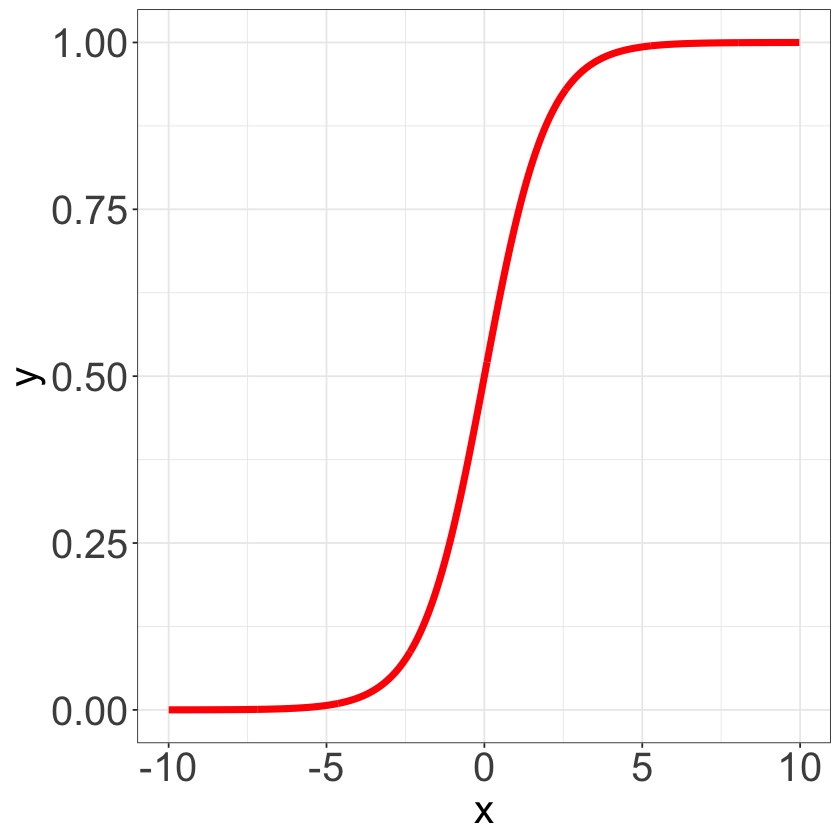

In [1]:
set.seed(20221011)
library(ggplot2)

x <- runif(1000, -10, 10)
y <- 1 / (1 + exp(-x))
ggplot(NULL, aes(x = x, y = y)) +
    geom_line(color = "red", size = 2) +
    theme_bw() +
    theme(
        text = element_text(size = 24),
        axis.title = element_text(size = 24),
        axis.text.y = element_text(size = 24),
        axis.text.x = element_text(size = 24)
    )

## The maximum likelihood estimation

- Recall that, the likelihood is the joint probability function of joint density function of the data.

- Here, we have independent observations $\left(\mathbf{x}_i, y_i\right), i=1, \ldots, n$, each follow the (conditional) distribution
$$
P\left(y_i=1 \mid \mathbf{x}_i\right)=\frac{1}{1+\exp \left(-\beta^T \mathbf{x}_i\right)}=1-P\left(y_i=0 \mid \mathbf{x}_i\right)
$$

- So, the joint probability function is
$$
\prod_{i=1, \ldots, n ; y_i=1} p\left(y_i=1 \mid \mathbf{x}_i\right) \prod_{i=1, \ldots, n ; y_i=0} p\left(y_i=0 \mid \mathbf{x}_i\right)
$$
which can be conveniently written as
$$
\prod_{i=1}^n \frac{\exp \left(y_i \beta^T \mathbf{x}_i\right)}{1+\exp \left(\beta^T \mathbf{x}_i\right)}
$$

- The likelihood function is the same as the joint probability function, but viewed as a function of $\beta$. The log-likelihood function is
$$
\ell=\sum_{i=1}^n\left[y_i \beta^T x_i-\log \left(1+\exp \left(\beta^T \mathbf{x}_i\right)\right)\right]
$$

- Unlike linear regression, we can no longer write down the MLE in closed form. Instead, we need to use optimization algorithms to compute it.
    - Gradient descent
    - Newton’s method

## Generate data

In [2]:
n <- 500 # Sample size
p <- 2 # Number of features

y <- c(rep(0, n / 2), rep(1, n / 2))
x_class1 <- matrix(rnorm(n / 2 * p), n / 2, p) - 1
x_class2 <- matrix(rnorm(n / 2 * p), n / 2, p) + 1
x <- rbind(x_class1, x_class2)
data <- as.data.frame(cbind(y, x))
names(data) <- c("y", paste("x", 1:p, sep = ""))

## Visualization

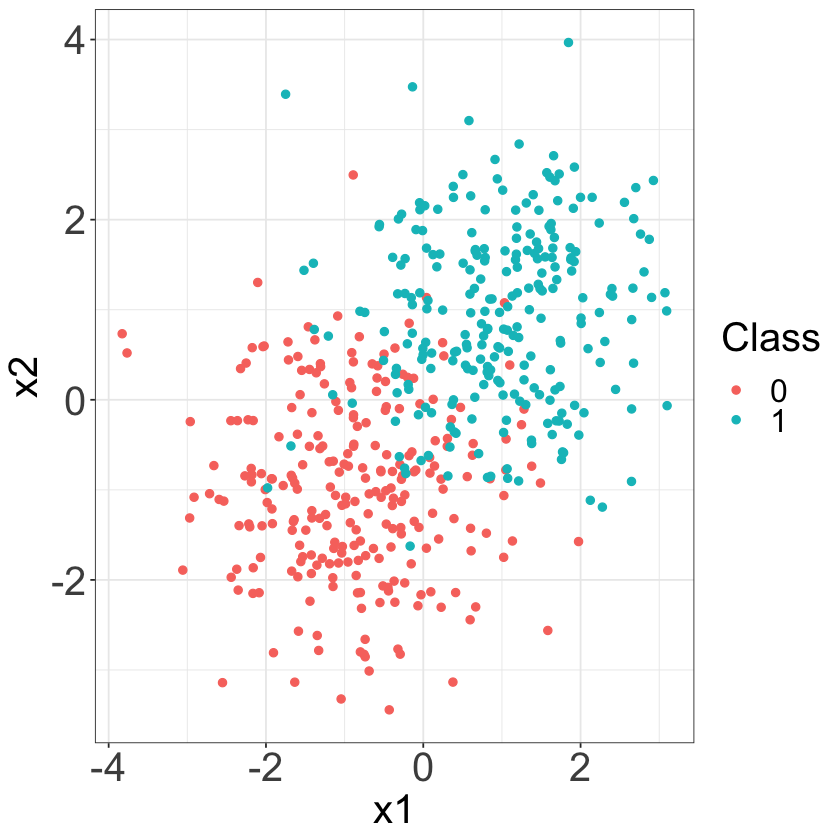

In [3]:
data$y <- as.factor(data$y)
ggplot(data = data, aes(x = x1, y = x2, color = y)) +
    geom_point(size = 2) +
    xlab("x1") +
    ylab("x2") +
    theme_bw() +
    theme(
        text = element_text(size = 24),
        axis.title = element_text(size = 24),
        axis.text.y = element_text(size = 24),
        axis.text.x = element_text(size = 24)
    ) +
    guides(color = guide_legend(title = "Class"))

## Implementation

In [4]:
mylogistic <- function(y, x, method = "Hessian", maxIter = 500) {
    n <- dim(x)[1]
    p <- dim(x)[2]

    x <- cbind(matrix(1, n, 1), x)
    XtX <- t(x) %*% x

    beta_old <- matrix(0, p + 1, 1)
    prob <- 1 / (1 + exp(-x %*% beta_old))

    for (iter in 1:maxIter) {
        if (method == "Hessian") {
            W <- prob * (1 - prob)
            temp <- matrix(rep(sqrt(W), p + 1), n, p + 1) * x
            XWX <- t(temp) %*% temp
            # Newton-Raphson update
            invH <- solve(XWX)
            beta <- beta_old + invH %*% (t(x) %*% (y - prob))
        } else {
            # This is a method using the upper bound of Hessian
            # Because prob*(1-prob) <= 0.25
            # We replace prob*(1-prob) by 0.25
            z <- 0.25 * x %*% beta_old + (y - prob)
            beta <- solve(0.25 * XtX) %*% (t(x) %*% z)
        }

        if (max(abs(beta_old - beta)) / sqrt(sum(beta^2)) < 1e-6) {
            break
        }

        prob <- 1 / (1 + exp(-x %*% beta))
        prob[prob > 0.999] <- 0.999
        prob[prob < 0.001] <- 0.001

        beta_old <- beta
    }

    se <- sqrt(diag(invH))
    return(list(prob = prob, beta = beta, se = se, Iter = iter))
}

In [5]:
my.fit <- mylogistic(y = as.numeric(data$y) - 1, x = as.matrix(data[, 2:3]), method = "Hessian")
my.fit$beta
my.fit$Iter
my.fit$se

,0.03591574
x1,1.73476330
x2,1.95298132


[1] 9

x1        x2 
0.1697727 0.1967436 0.2279069

## Built-in `glm()` function

In [6]:
glm.fit <- glm(y ~ x1 + x2, family = "binomial", data = data)
summary(glm.fit)


Call:
glm(formula = y ~ x1 + x2, family = "binomial", data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8077  -0.2547  -0.0008   0.2588   3.2565  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.03569    0.16967   0.210    0.833    
x1           1.73164    0.19734   8.775   <2e-16 ***
x2           1.94891    0.22879   8.518   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 693.15  on 499  degrees of freedom
Residual deviance: 229.39  on 497  degrees of freedom
AIC: 235.39

Number of Fisher Scoring iterations: 7


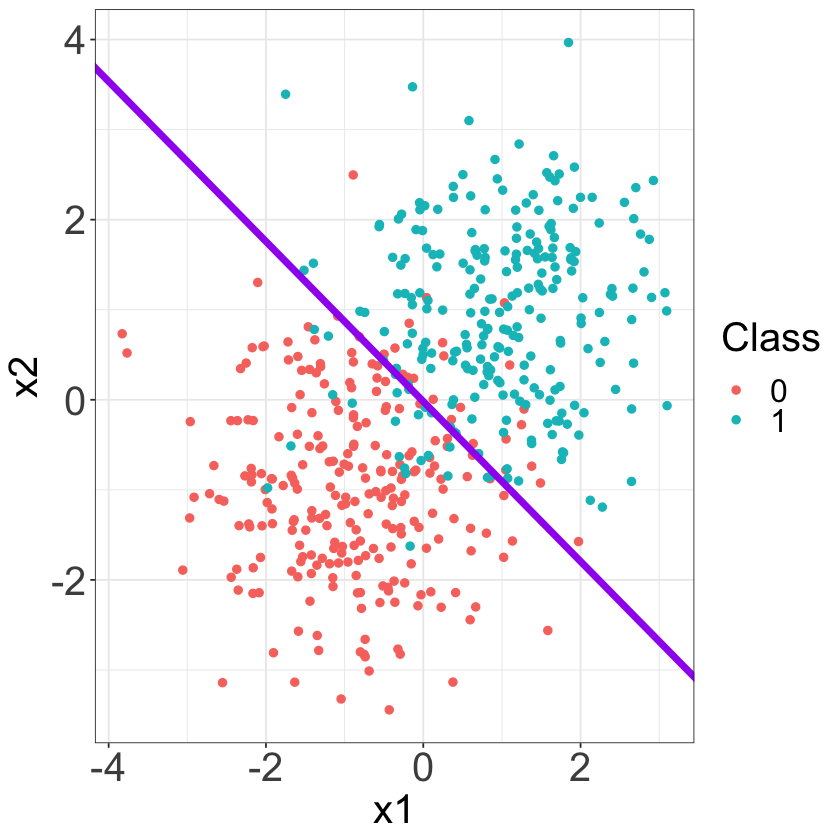

In [7]:
ggplot(data = data, aes(x = x1, y = x2, color = y)) +
    geom_point(size = 2) +
    geom_abline(intercept = - my.fit$beta[1, 1] / my.fit$beta[3, 1], slope = - my.fit$beta[2, 1] / my.fit$beta[3, 1], size = 2, color = "purple") +
    xlab("x1") +
    ylab("x2") +
    theme_bw() +
    theme(
        text = element_text(size = 24),
        axis.title = element_text(size = 24),
        axis.text.y = element_text(size = 24),
        axis.text.x = element_text(size = 24)
    ) +
    guides(color = guide_legend(title = "Class"))

## Multiclass logistic regression

We now extend the two-class logistic regression approach to the setting of $K > 2$ classes.
This extension is known as multiclass logistic regression or multinomial logistic regression.

To do this, we first select a single class to serve as the **baseline** (why?); without loss of generality, we select the $K$-th class for this role.
Then
$$
\operatorname{Pr}(Y=k \mid X=x)=\frac{e^{\beta_{k 0}+\beta_{k 1} x_1+\cdots+\beta_{k p} x_p}}{1+\sum_{l=1}^{K-1} e^{\beta_{l 0}+\beta_{l 1} x_1+\cdots+\beta_{l p} x_p}}
$$
for $k=1, \ldots, K-1$, and
$$
\operatorname{Pr}(Y=K \mid X=x)=\frac{1}{1+\sum_{l=1}^{K-1} e^{\beta_{l 0}+\beta_{l 1} x_1+\cdots+\beta_{l p} x_p}} .
$$
It is not hard to show that for $k=1, \ldots, K-1$,
$$
\log \left(\frac{\operatorname{Pr}(Y=k \mid X=x)}{\operatorname{Pr}(Y=K \mid X=x)}\right)=\beta_{k 0}+\beta_{k 1} x_1+\cdots+\beta_{k p} x_p
$$
**Notice that the log odds between any pair of classes is linear in the features.**

## A toy example

### Generate data

In [8]:
N <- 1000 # Sample size
P <- 2 # Number of features
K <- 3 # Number of classes

X <- matrix(rnorm(N * P), N, P) # Features, N * P
b <- matrix(rnorm(P * (K - 1), mean = 3), P, K - 1) # Coefficients, P * (K - 1)

head(X)
head(b)

-1.4336430,0.6504344
0.4086914,0.6397878
-2.3707612,-2.9148359
1.9045292,1.0788753
-1.2850531,0.5210702
-0.7488323,0.5531552


2.740818,3.694708
4.567395,3.681986


In [9]:
f <- exp(X %*% b) # N * (K - 1)
prob <- f / (1 + rowSums(f)) # Prob of Class 1 and 2, N * (K - 1)
prob <- cbind(prob, 1 - rowSums(prob)) # Prob of Class 1, 2, and 3, N * K

head(f)
head(prob)

3.834431e-01,5.491315e-02
5.695787e+01,4.773597e+01
2.489882e-09,3.426740e-09
2.553019e+04,6.042049e+04
3.191279e-01,5.905280e-02
1.606511e+00,4.819054e-01


2.665842e-01,3.817771e-02,6.952380e-01
5.388949e-01,4.516438e-01,9.461288e-03
2.489882e-09,3.426740e-09,1.000000e+00
2.970295e-01,7.029588e-01,1.163444e-05
2.315573e-01,4.284838e-02,7.255943e-01
5.201731e-01,1.560364e-01,3.237905e-01


In [10]:
y <- t(apply(prob, 
             MARGIN = 1, 
             FUN = function(x) {rmultinom(n = 1, size = 1, prob = x)}))
head(y) # Each column represents a class

0,0,1
1,0,0
0,0,1
0,1,0
0,0,1
1,0,0


[1] 3 1 3 2 3 1
Levels: 1 2 3

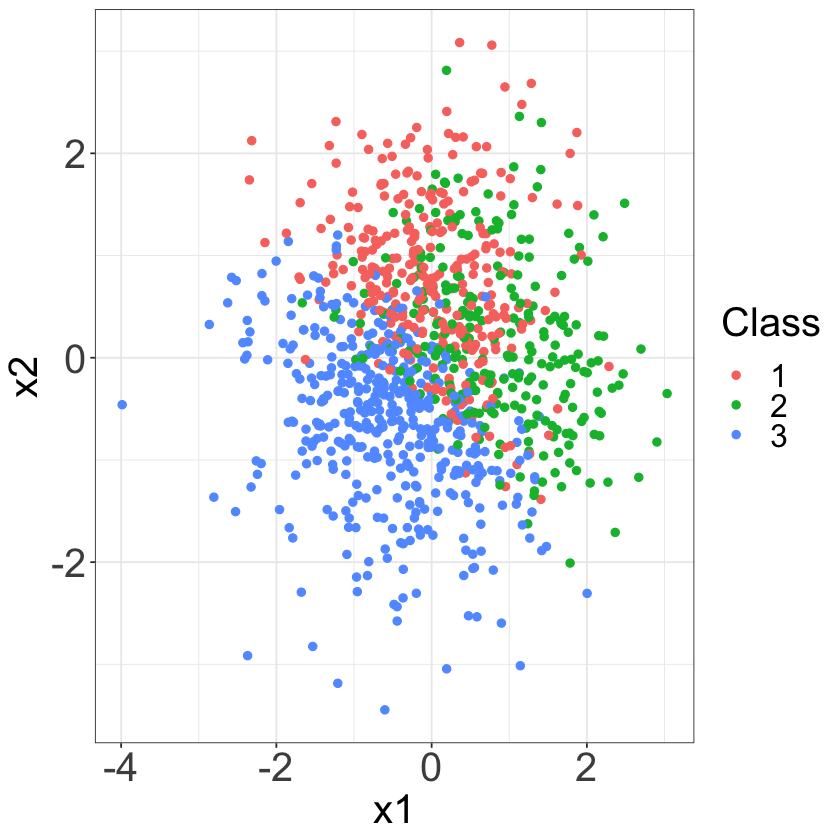

In [11]:
# Visulization

## Encode to 1, 2, and 3
classEncode <- function(x){
    if(x[1] == 1){
        return(1)
    }else if (x[2] == 1){
        return(2)
    }else{
        return(3)
    }
}

y_encode <- as.vector(apply(y, MARGIN = 1, FUN = classEncode))
y_encode <- factor(y_encode, levels = c(1, 2, 3))
y_encode[1:6]

## ggplot2
ggplot(data = NULL, aes(x = X[, 1], y = X[, 2], color = y_encode)) +
    geom_point(size = 2) +
    xlab("x1") +
    ylab("x2") +
    theme_bw() +
    theme(
        text = element_text(size = 24),
        axis.title = element_text(size = 24),
        axis.text.y = element_text(size = 24),
        axis.text.x = element_text(size = 24)
    ) +
    guides(color = guide_legend(title = "Class"))

### Now let's fit multiclass logistic regression!

In [12]:
multLogReg <- function(X, y, b_init = NULL, lambda = 0, tol = 1e-4, inner_iter = 100, outer_iter = 100) {
    # Data dimension
    P <- dim(X)[2]
    N <- dim(y)[1]
    K <- dim(y)[2]

    # Start solving

    X <- cbind(rep(1, N), X) # Add the intercept

    XtX <- t(X) %*% X
    Lambda <- diag(c(0, rep(lambda, P)))

    if (is.null(b_init)) {
        b <- matrix(0, P + 1, K - 1) # Allow different initialization of beta0
    } else {
        b <- b_init
    }

    b_old <- b
    f <- exp(X %*% b_old)
    prob <- f / (1 + rowSums(f))
    # prob <- 1 / (1 + exp(-X %*% b_old))

    for (out in 1:outer_iter) { # Out iteration
        for (l in 1:(K - 1)) {
            for (inner in 1:inner_iter) { # Inner iteration
                # diag_W <- prob * (1 - prob)
                b_tmp <- b[, l] # Coefficients of l-th class
                # z <- 0.25 * X %*% as.matrix(b_tmp) + (y[, l + 1] - prob[, l]) # Use 1-st class as baseline
                z <- 0.25 * X %*% as.matrix(b_tmp) + (y[, l] - prob[, l]) # Use last class as baseline
                b[, l] <- solve(0.25 * XtX + Lambda) %*% (t(X) %*% z)

                if (max(abs(b_tmp - b[, l])) / norm(as.matrix(b[, l]), "F") < tol) {
                    break
                }

                f[, l] <- exp(X %*% b[, l])
                prob <- f / (1 + rowSums(f))

                # Safe guard
                prob[prob > 0.999] <- 0.999
                prob[prob < 0.001] <- 0.001
            }
        }

        if (max(abs(b_old - b)) / norm(b, "F") < tol) {
            break
        }

        b_old <- b
    }

    return(b = b)
}

In [13]:
b_hat <- multLogReg(X, y)
b_hat

0.1481288,-0.06697149
2.6863751,3.78580763
4.5149954,3.79156715


Remember that for $k=1, \ldots, K-1$,
$$
\log \left(\frac{\operatorname{Pr}(Y=k \mid X=x)}{\operatorname{Pr}(Y=K \mid X=x)}\right)=\beta_{k 0}+\beta_{k 1} x_1+\cdots+\beta_{k p} x_p.
$$
Let $\frac{\operatorname{Pr}(Y=k \mid X=x)}{\operatorname{Pr}(Y=K \mid X=x)} = 1$, we can get
$$
\beta_{k 0}+\beta_{k 1} x_1+\cdots+\beta_{k p} x_p = 0.
$$
In this case $p = 2$, so
$$
\beta_{k 0}+\beta_{k 1} x_1+\beta_{k 2} x_2 = 0,\\
x_2 = - \frac{\beta_{k 0}}{\beta_{k 2}} - \frac{\beta_{k 1}}{\beta_{k 2}} x_1.
$$

Suppose we do not know which is the **baseline** class and assume it was chosen at random. (Actually we know it.)

Let's first visualize the known classification line.

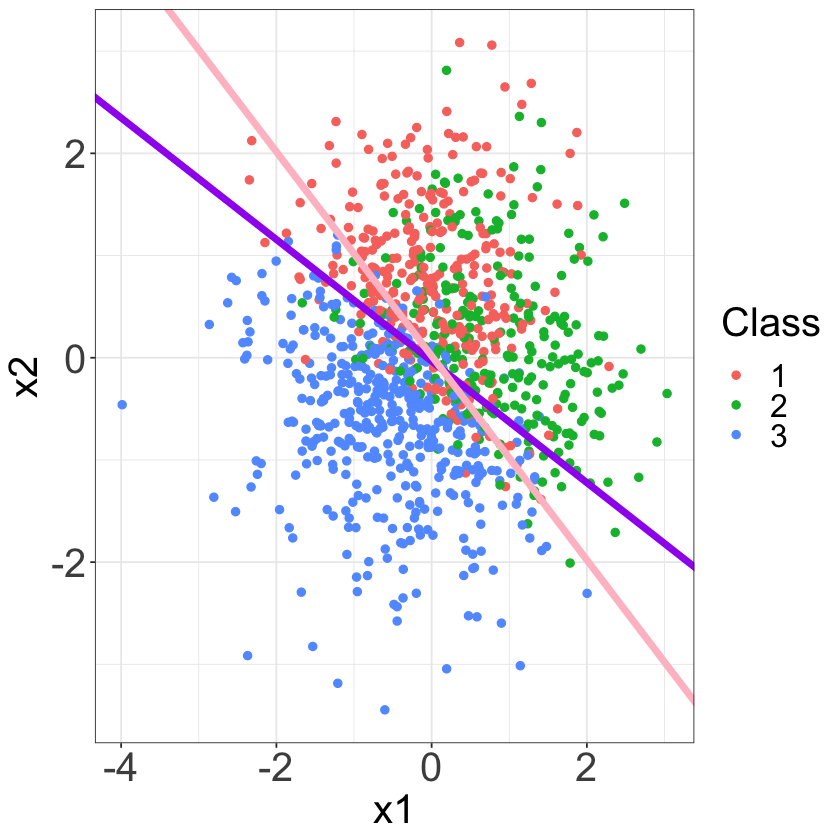

In [14]:
ggplot(data = NULL, aes(x = X[, 1], y = X[, 2], color = y_encode)) +
    geom_point(size = 2) +
    geom_abline(intercept = - b_hat[1, 1] / b_hat[3, 1], slope = - b_hat[2, 1] / b_hat[3, 1], size = 2, color = "purple") +
    geom_abline(intercept = - b_hat[1, 2] / b_hat[3, 2], slope = - b_hat[2, 2] / b_hat[3, 2], size = 2, color = "pink") +
    xlab("x1") +
    ylab("x2") +
    theme_bw() +
    theme(
        text = element_text(size = 24),
        axis.title = element_text(size = 24),
        axis.text.y = element_text(size = 24),
        axis.text.x = element_text(size = 24)
    ) +
    guides(color = guide_legend(title = "Class"))

In [15]:
b_hat

0.1481288,-0.06697149
2.6863751,3.78580763
4.5149954,3.79156715


We can see that the purple line is between class 1 and 3, and the pink line is between class 2 and 3.
So the **baseline** here is class 3, and
$$
\log \left(\frac{\operatorname{Pr}(Y=1 \mid X=x)}{\operatorname{Pr}(Y=3 \mid X=x)}\right) = 0.15 + 2.69 x_1 + 4.51 x_2, \\
\log \left(\frac{\operatorname{Pr}(Y=2 \mid X=x)}{\operatorname{Pr}(Y=3 \mid X=x)}\right) = -0.07 + 3.79 x_1 + 3.79 x_2.
$$
Therefore,
$$
\log \left(\frac{\operatorname{Pr}(Y=1 \mid X=x)}{\operatorname{Pr}(Y=2 \mid X=x)}\right) = (0.15-(-0.07)) + (2.69 - 3.79) x_1 + (4.51 - 3.79) x_2.
$$

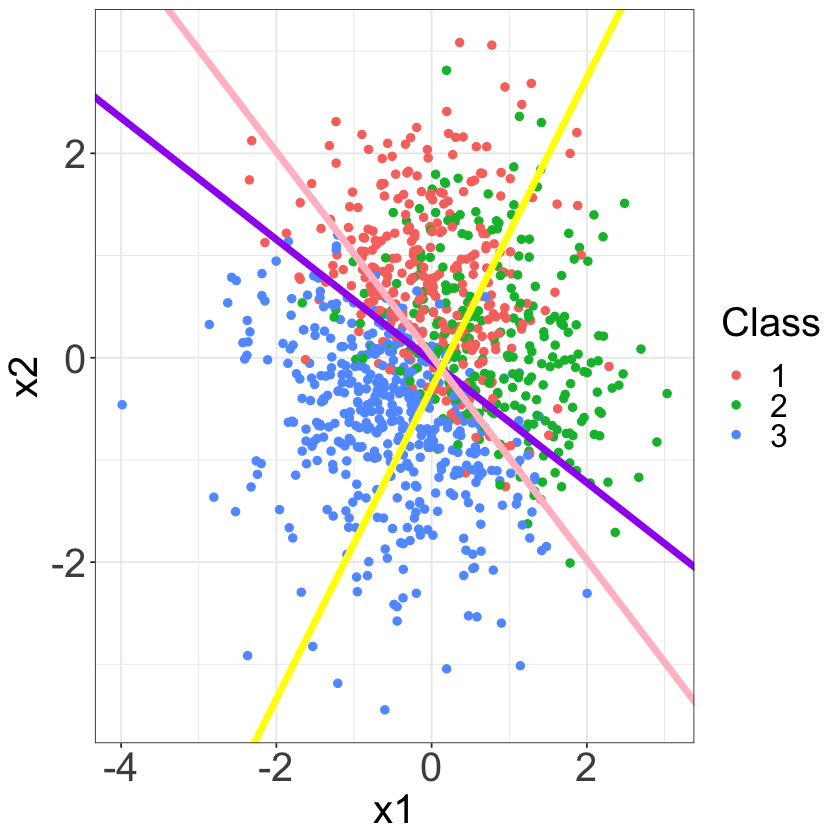

In [16]:
# The full figure
ggplot(data = NULL, aes(x = X[, 1], y = X[, 2], color = y_encode)) +
    geom_point(size = 2) +
    geom_abline(intercept = - b_hat[1, 1] / b_hat[3, 1], slope = - b_hat[2, 1] / b_hat[3, 1], size = 2, color = "purple") +
    geom_abline(intercept = - b_hat[1, 2] / b_hat[3, 2], slope = - b_hat[2, 2] / b_hat[3, 2], size = 2, color = "pink") +
    geom_abline(intercept = - (b_hat[1, 1] - b_hat[1, 2]) / (b_hat[3, 1] - b_hat[3, 2]), slope = - (b_hat[2, 1] - b_hat[2, 2]) / (b_hat[3, 1] - b_hat[3, 2]), size = 2, color = "yellow") +
    xlab("x1") +
    ylab("x2") +
    theme_bw() +
    theme(
        text = element_text(size = 24),
        axis.title = element_text(size = 24),
        axis.text.y = element_text(size = 24),
        axis.text.x = element_text(size = 24)
    ) +
    guides(color = guide_legend(title = "Class"))